<a href="https://colab.research.google.com/github/CCMunozB/Patrones/blob/main/8-RNN_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Recurrentes (RNN)

Continuando con el estudio de las redes profundas, las redes recurrentes poseen la caracteristicas de guardar la información previa y entregarsela a la siguiente capa, con el fin de mantener la información secuencial de los datos.

![texto del vínculo](https://www.simplilearn.com/ice9/free_resources_article_thumb/Fully_connected_Recurrent_Neural_Network.gif)

In [1]:
!pip install -q nltk

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!gdown 1JEFdSRQ08RESzPBaBJVlzXRsvO6tdZ14 -O Symptom2Disease.csv

Downloading...
From: https://drive.google.com/uc?id=1JEFdSRQ08RESzPBaBJVlzXRsvO6tdZ14
To: /content/Symptom2Disease.csv
100% 230k/230k [00:00<00:00, 141MB/s]


## Symptom2Disease ([Link](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease))




In [4]:
dat = pd.read_csv('Symptom2Disease.csv')
dat.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [5]:
#24 Labels
dat['label'].value_counts()

Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: label, dtype: int64

In [6]:
dat['text'][0]

'I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'

## Preprocesamiento

codigo de preprocesamiento modificado desde [kaggle](https://www.kaggle.com/code/yannansu/symptom2disease-with-neural-networks-92-accuracy#Build-and-train-model)

### Label Encoder

In [7]:
def label_encode(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    label_sequences = label_encoder.transform(labels)
    return label_sequences

# test: random sample 5 labels in dat and corresponding sequences
for i in np.random.randint(0, len(dat['label']), 5):
    print(dat['label'][i], label_encode(dat['label'])[i])

dat['label_encoded'] = label_encode(dat['label'])

Arthritis 1
Jaundice 11
Chicken pox 4
diabetes 19
Impetigo 10


### Train - Test split

In [8]:
train_ratio = 0.8
# sample 80% of the data for training and 20% for validation for each label
train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
val = dat.drop(train.index)

train_texts = train['text'].values
train_labels = train['label_encoded'].values
val_texts = val['text'].values
val_labels = val['label_encoded'].values

train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape

((960,), (960,), (240,), (240,))

### Remover stopwords

In [9]:
def remove_stopwords(texts):
    # first remove all punctuations 
    words = [re.split(r'[ ,.]+', text) for text in texts]

    # remove space and make all words lower case
    words = [[word.lower() for word in text if word != ''] for text in words]

    # remove stop words using nltk (or you can use your own stop words, see below)
    stop_words = set(stopwords.words('english'))

    words = [[word for word in text if word.lower() not in stop_words] for text in words]
    return words

print(train_texts[0])
# test the function
print()
print(remove_stopwords(train_texts)[0])

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.

['nasty', 'rash', 'appeared', 'skin', 'blackheads', 'pimples', 'packed', 'pus', 'everywhere', 'additionally', 'skin', 'extremely', 'sensitive']


In [10]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words, tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
print(train_texts[0], end="\n\n")
print(len(train_texts[0].split(" ")), end="\n\n")
tokenize_and_pad(train_texts, tokenizer)[0]

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.

24



array([  5, 287,  46,  13, 177, 562,  22,   3,  16, 133,   2,  92, 637,
        24, 134,  18, 400,  89,   3,  16,  13,   6,  98, 269,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [11]:
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(val_texts), tokenizer)
val_labels = val_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('val_sequences shape: ', val_sequences.shape)
print('val_labels shape: ', val_labels.shape)

train_sequences shape:  (960, 50)
train_labels shape:  (960, 1)
val_sequences shape:  (240, 50)
val_labels shape:  (240, 1)


In [12]:
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

## Modelos

![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LfH52lSd1mq-UrWuejzO8g.png)

In [13]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, early_stop]

In [14]:
max_length = 50

# build the model with GRU layer
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 256, input_length=max_length),
    tf.keras.layers.GRU(64, go_backwards=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')]) 

model_GRU.summary()
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 256)           768000    
                                                                 
 gru (GRU)                   (None, 64)                61824     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 832,696
Trainable params: 832,696
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model_GRU.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels), callbacks=get_callbacks())

Epoch 1/30
30/30 [==============================] - 14s 181ms/step - loss: 3.1443 - accuracy: 0.1250 - val_loss: 3.0774 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - 4s 131ms/step - loss: 2.8399 - accuracy: 0.2333 - val_loss: 2.5103 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 2s 72ms/step - loss: 1.9828 - accuracy: 0.4479 - val_loss: 1.7093 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 1s 22ms/step - loss: 1.0455 - accuracy: 0.8021 - val_loss: 1.0220 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 1s 44ms/step - loss: 0.4999 - accuracy: 0.9354 - val_loss: 0.7491 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - 1s 29ms/step - loss: 0.2549 - accuracy: 0.9781 - val_loss: 0.5690 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - 0s 7ms/step - loss: 0

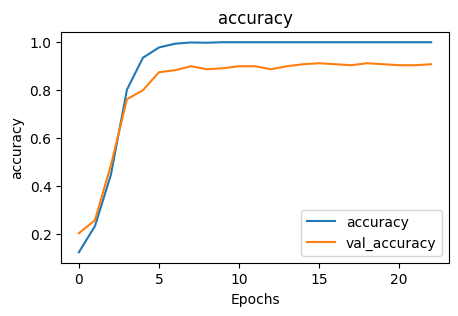

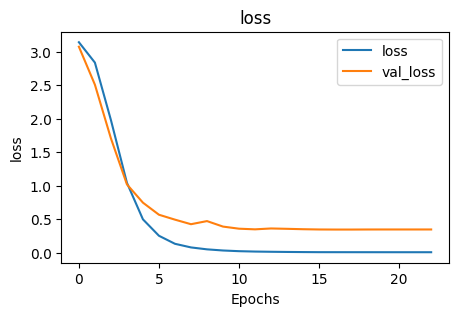

In [16]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Actividad 1
Visualice la evolución de los pesos de la predicción al añadir secuencialmente palabras como input Ej:



```
Frase : I've just developed a skin rash with several pus-filled pimples and blackheads.

Input 1: I've
Input 2: I've just
Input 3: I've just developed
...
Input N: I've just developed a skin rash with several pus-filled pimples and blackheads.
```



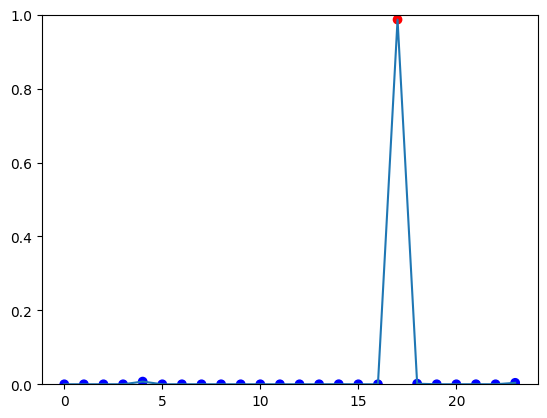

 The skin around the veins on my legs is dry and flaky. It seems there is a major bruise and my legs have started to swell.

True Label : Varicose Veins = 17


In [18]:
#Hint la función de remove_stopwords acepta un arreglo con arreglos "#0000FF"

from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep
import pandas as pd

num = 69

frase = dat["text"][num].split(" ")
in_frase = ""
color = "#0000FF"
colors = [color] * 24
colors[dat['label_encoded'][num]] = "#FF0000"

for palabra in frase:
  in_frase = in_frase + " " + palabra 
  input = tokenize_and_pad(remove_stopwords([in_frase]), tokenizer)
  pred = model_GRU.predict(input)
  sleep(2)
  clear_output(wait=True)
  plt.scatter(range(24),pred[0],color=colors)
  plt.plot(pred[0])
  plt.ylim([0,1])
  plt.show()
  print(in_frase)

print()
print(f"True Label : {dat['label'][num]} = {dat['label_encoded'][num]}")

## Actividad 2
Entrene un nuevo modelo cambiando la capa GRU por una capa LTSM y compare los resultados
![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*7cMfenu76BZCzdKWCfBABA.png)

In [ ]:
# build the model with GRU layer
model_LTSM = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 256, input_length=max_length),
    tf.keras.layers.LSTM(64, go_backwards=True, dropout=0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')])

model_LTSM.summary()
model_LTSM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 256)           768000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                82176     
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 24)                792       
                                                                 
Total params: 853,048
Trainable params: 853,048
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_LTSM.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels), callbacks=get_callbacks())

Epoch 1/30
30/30 [==============================] - 6s 132ms/step - loss: 3.1194 - accuracy: 0.2031 - val_loss: 2.9574 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - 3s 88ms/step - loss: 2.5627 - accuracy: 0.2750 - val_loss: 2.1508 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 2s 56ms/step - loss: 1.6090 - accuracy: 0.5521 - val_loss: 1.3149 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 1s 46ms/step - loss: 0.8245 - accuracy: 0.8500 - val_loss: 0.8513 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 1s 26ms/step - loss: 0.4288 - accuracy: 0.9563 - val_loss: 0.6390 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - 1s 16ms/step - loss: 0.2025 - accuracy: 0.9927 - val_loss: 0.4724 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - 0s 11ms/step - loss: 0.

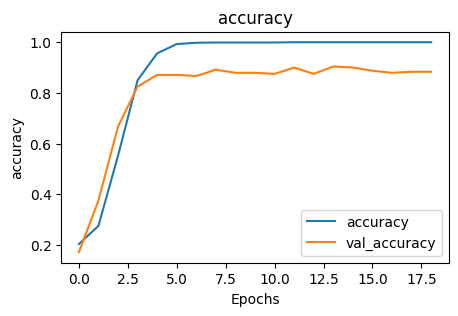

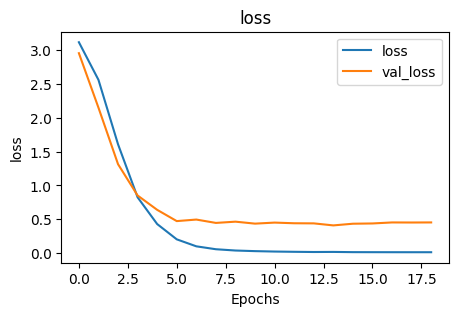

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')